# Deep Dream

## Copyright notice

This version (c) 2019 Fabian Offert, [MIT License](LICENSE). 

## Background

In the summer of 2015, strange images started to appear on the Internet. On July 2nd, on Twitter, user @big_soda69 posted a [photo of a bear that seemed to have been made out of dogs](https://twitter.com/big_soda69/status/616731105350275072), with dog faces and muliple dog legs sticking out of his fur.

![](img/tweet.jpg)

The day before, user bskaggs had already posted a gallery of ["Inceptionism Art"](https://imgur.com/a/nVlLe) (!) on Imgur, a popular image sharing platform often used together with Reddit. More images appeared shortly after, on Twitter and other social media platforms, all showing similar transformations of everyday objects into nightmarish but colorful assemblages of animal body parts.

The source of these images was a computer program that was [released on GitHub](https://github.com/google/deepdream/) on July 1st, 2015. Already on June 17th, a [post on the Google Research Blog](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) had described the work behind the program, and had showed some of the generated images. The release of the source code, and [a reference to it posted to the popular news aggregator Hacker News](https://news.ycombinator.com/item?id=9815873) on July 2nd, 2015  accelerated the original post's and the source code's distribution all over the Internet, eventually leading to users trying the program on their own images. The hacker news post also referred to the program as "Deep Dream", chosing the name of the GitHub repository, and not "Inceptionism", as it was called in the original blog post. Eventually, the name "Deep Dream" would become the commonly used term for this class of visualization techniques.

On the technical level, the name "Deep Dream" references two significant aspects of the program: the fact that it was structured as a deep artificial neural network, and the fact that this neural network was used in an unusual way not to classify, but to generate images.

In the following, we are reconstructing the algorithm used to create these and many other images. As the original source code was based on the Caffe framework, which, in the meantime, has become somewhat niche, we are implementing it in PyTorch. Google also maintains a [plain Tensorflow example](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/tutorials/deepdream/deepdream.ipynb).

## Imports

To be able to use mechanisms like differentiation and backpropagation we need a high-level library that abstracts these mathematical details away from us. We are using PyTorch, one of the de-facto standard frameworks for high-level prototyping for machine learning. We are also importing an existing, slightly modified network architecture: InceptionV3. Because we are operating in high-dimensional vector space, we are also using Numpy, the Python library for scientific computing. Finally, we are importing a bunch of helper functions to render images within the notebook environment.

In [1]:
import torch as t
import torch.nn as nn
import torchvision as tv
import numpy as np
import os

from io import BytesIO
import PIL.Image
import IPython.display

from inception_debug import inception_v3

CUDA = False # Set this to True if using a GPU

## Settings

According to the original blog post, we "pick a layer and ask the network to enhance whatever it detected." Here is an overview of the architecture of InceptionV3 (more information [here](https://hacktilldawn.com/2016/09/25/inception-modules-explained-and-implemented/) and in the [original paper](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Szegedy_Rethinking_the_Inception_CVPR_2016_paper.pdf)):
    
![](img/inception.jpg)

How do we know how these layers are called? We can simply load the model, add pre-trained ImageNet weights to it, and iterate over the available layers:

In [2]:
model = None
if CUDA:
    model = inception_v3(pretrained=True).cuda()
else:
    model = inception_v3(pretrained=True)
# Test mode
model.eval()

print('Available modules:')
for n, name_module in enumerate(model.named_children()):
    print(n, name_module[0])

f = model # Alias

Available modules:
0 Conv2d_1a_3x3
1 Conv2d_2a_3x3
2 Conv2d_2b_3x3
3 Conv2d_3b_1x1
4 Conv2d_4a_3x3
5 Mixed_5b
6 Mixed_5c
7 Mixed_5d
8 Mixed_6a
9 Mixed_6b
10 Mixed_6c
11 Mixed_6d
12 Mixed_6e
13 AuxLogits
14 Mixed_7a
15 Mixed_7b
16 Mixed_7c
17 fc


In [3]:
def deprocess(tensor):
    # Remove batch dimension
    # Shape before: BCSS
    tensor = tensor.data.squeeze() 
        
    # To CPU and numpy array
    img = tensor.cpu().numpy() 
    
    # Channels last
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 0, 1)

    # Clip to visible range
    img = np.clip(img, 0., 1.) # Clip to 0./1. range
        
    # 0./1. range to 0./255. range
    img *= 255. 
    
    # To PIL image format
    img = PIL.Image.fromarray(img.astype(np.uint8))  
    
    return img
    
def show_img_PIL(img, fmt='jpeg'):
    f = BytesIO()
    img.save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [45]:
def gradient_ascent(img, layer):
            
    ITERATIONS = 15 # 50
    JITTER = 32
    LR = 0.15 # 0.4
    L2 = 1e-4 # 1e-4
    
    # Pytorch is channels first, this happens here!
    preprocess = tv.transforms.Compose([tv.transforms.ToTensor()])
    
    # unsqueeze(0) adds batch dimension
    # cuda() puts on GPU
    # requires_grad_() switches on gradients (gradients for the model are switched off in model.eval())
    input = None
    if CUDA:
        input = preprocess(img).unsqueeze(0).cuda().requires_grad_()
    else:
        input = preprocess(img).unsqueeze(0).requires_grad_()
    
    optimizer = t.optim.SGD([input], lr=LR, weight_decay=L2)
    
    for i in range(ITERATIONS):
        
        optimizer.zero_grad()
        
        if JITTER:
            npimg = input.data.cpu().numpy() # To CPU and numpy
            ox, oy = np.random.randint(-JITTER, JITTER+1, 2)
            npimg = np.roll(np.roll(npimg, ox, -1), oy, -2) # Jitter
            if CUDA:
                input.data = t.from_numpy(npimg).cuda()
            else:
                input.data = t.from_numpy(npimg)
        
        # To make different input sizes work, in inception.py, line 117, replace
        # x = F.avg_pool2d(x, kernel_size=8)
        # with
        # x = F.adaptive_avg_pool2d(x, output_size=(1,1))
        # See https://discuss.pytorch.org/t/how-to-create-convnet-for-variable-size-input-dimension-images/1906/3
        
        # Custom forward() function in inception_debug.py to keep all the extra stuff from the default
        # forward() function while going through the model layer by layer
        x = f.forward_layer(input, layer) # Forward pass up to the feature extractor layer

        # See https://pytorch.org/docs/stable/torch.html#torch.norm,
        # equivalent to Keras K.maximum(K.mean(K.abs(x)), K.epsilon())
        loss = -x.norm()
        # loss = -x[:,neuron] # Prediction layer
        
        loss.backward()
        optimizer.step()
        
        if JITTER:
            npimg = input.data.cpu().numpy() # To CPU and numpy
            npimg = np.roll(np.roll(npimg, -ox, -1), -oy, -2) # Jitter
            if CUDA:
                input.data = t.from_numpy(npimg).cuda()
            else:
                input.data = t.from_numpy(npimg)
                
    img = deprocess(input)
    return img

In [52]:
def generate(img,
             layer,
             octaves=5, 
             scale=1.2, 
             verbose=False):
    
    aa = PIL.Image.ANTIALIAS

    # Prepare octaves (only for square images!)
    original_shape = (img.width, img.height)
    successive_shapes = [original_shape]
    for i in range(1, octaves):
        w = int(successive_shapes[i-1][0]/scale)
        h = int(successive_shapes[i-1][0]/scale)
        successive_shapes.append((w,h))
    successive_shapes = successive_shapes[::-1]
    
    # Excplicitly input image
    final_img = img.copy()

    # Do octaves
    shrunk_final_img = img.resize(successive_shapes[0])
    for octave, shape in enumerate(successive_shapes):
        
        if verbose:
            print('octave', octave+1, '/', octaves, 'shape', shape)

        # Resize image to current shape
        img = img.resize(shape, aa)
        
        # Run gradient ascent
        img = gradient_ascent(img, layer)

        # Resize ("upscale") previous shape original image to current shape
        upscaled_shrunk_final_img = shrunk_final_img.resize(shape, aa)

        # Resize ("downscale") original shape original image to current shape
        same_size_final_img = final_img.resize(shape, aa)

        # Find the details that are lost in the upscaling process (in numpy space)
        lost_detail = np.array(same_size_final_img) - np.array(upscaled_shrunk_final_img)

        # Add these details back to the optimized image (in numpy space)
        img = np.array(img) + lost_detail

        # To PIL
        img = PIL.Image.fromarray(img)

        # Prepare for next ocatve
        shrunk_final_img = final_img.resize(shape, aa)

        # Show with autotone
        if verbose:
            show_img_PIL(img)
        
    return img

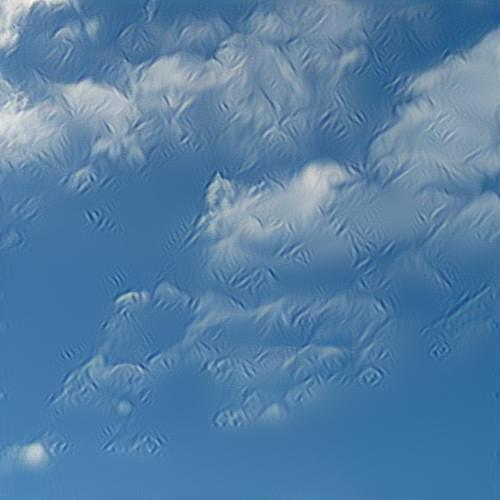

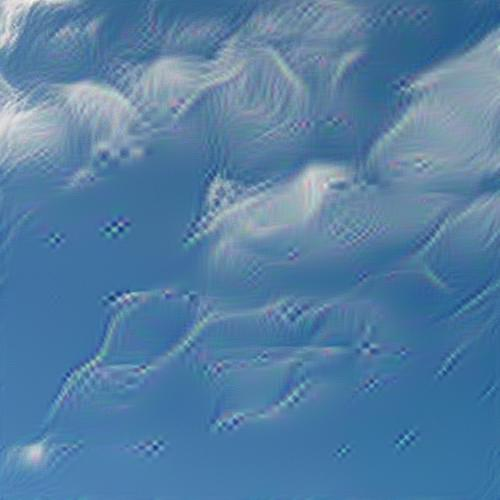

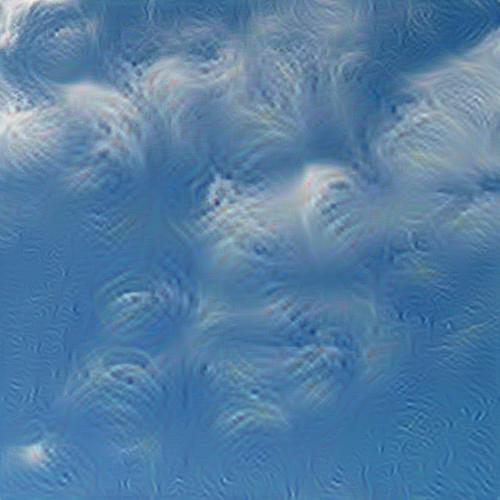

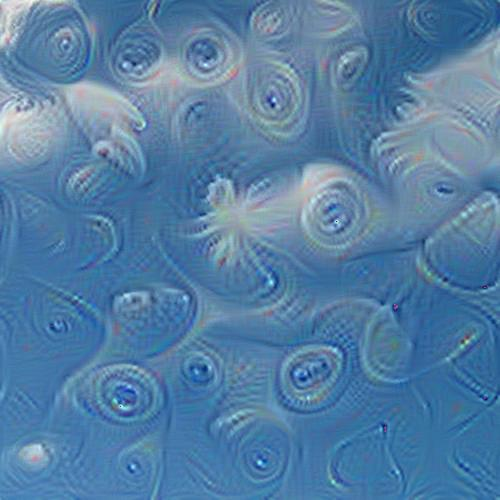

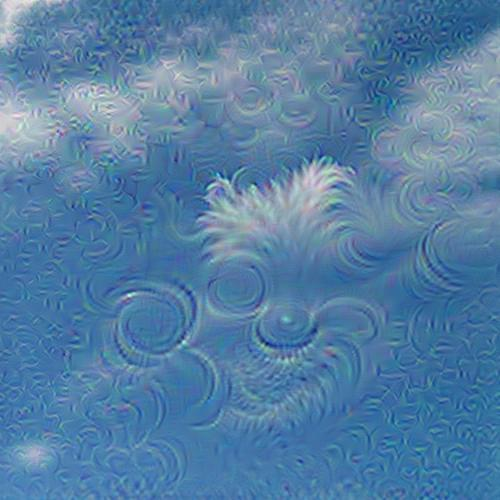

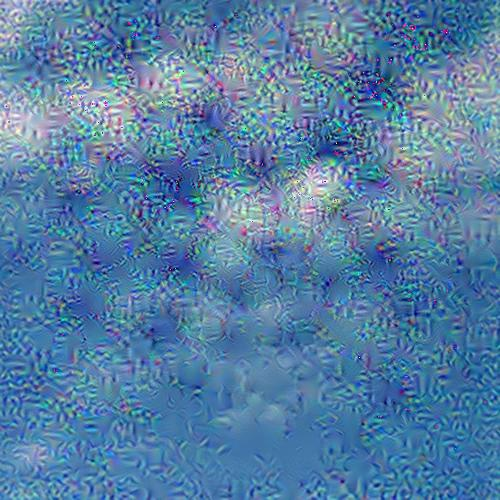

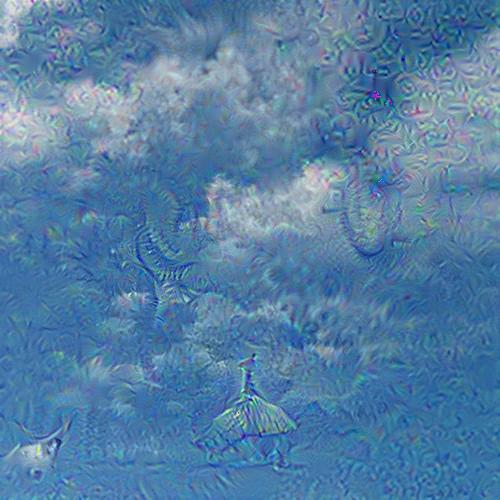

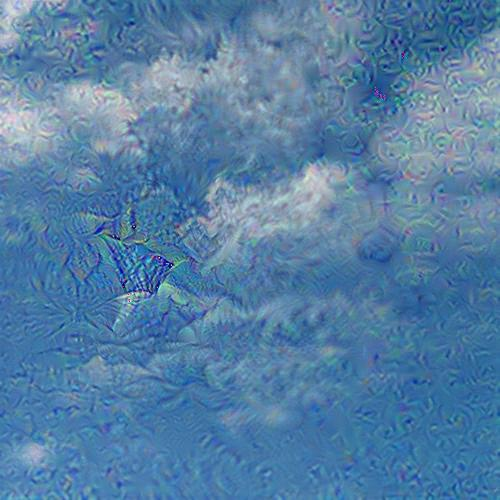

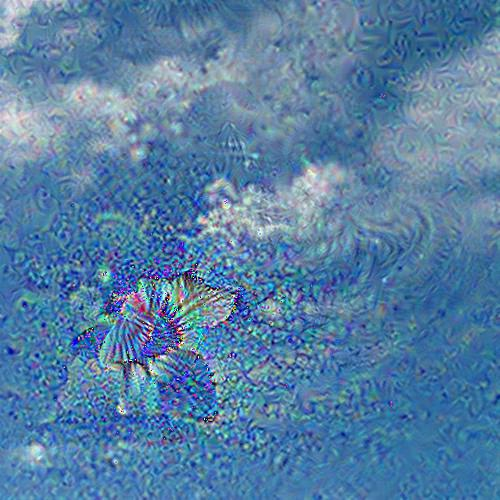

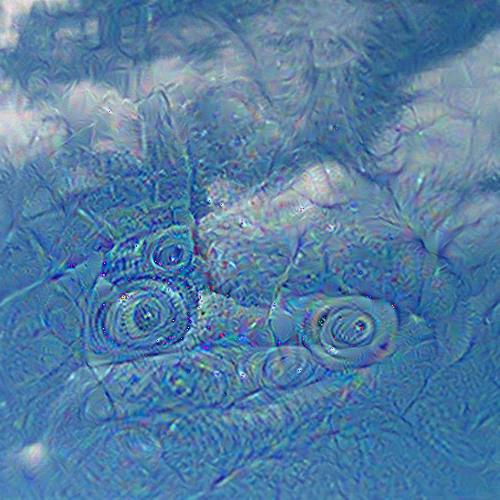

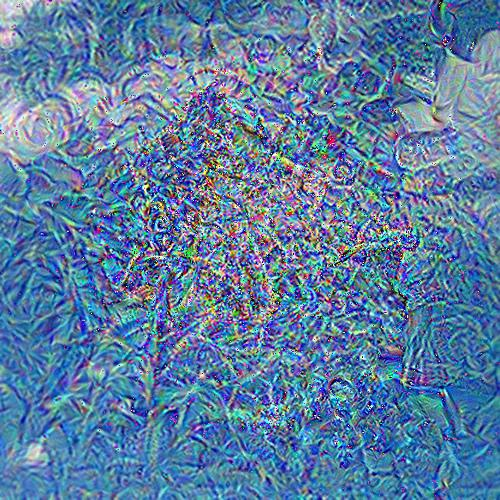

In [53]:
for layer in [5,6,7,8,9,10,11,12,14,15,16]:
    show_img_PIL(generate(img=PIL.Image.open('img/clouds.jpg'), layer=layer))